0
1
2
3
4
5
6
7
8
9
a matrix fit and real


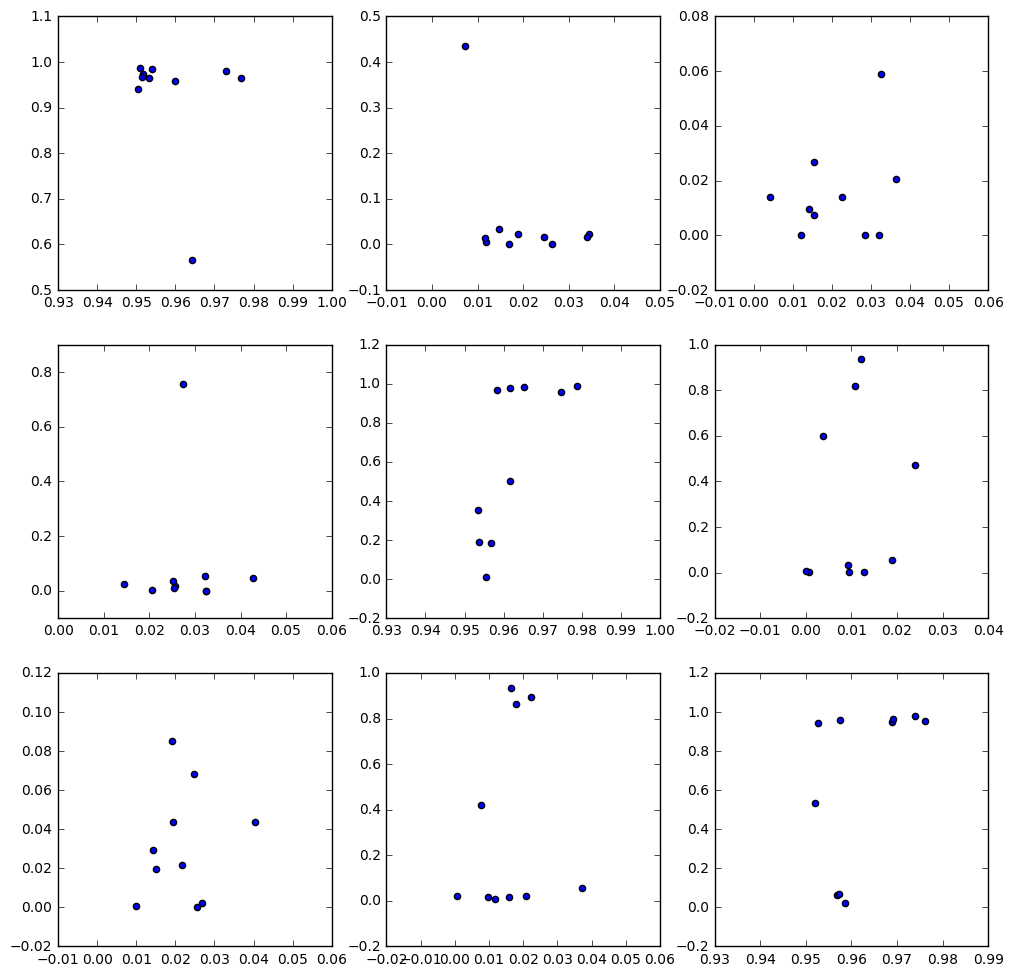

Viterbi scores


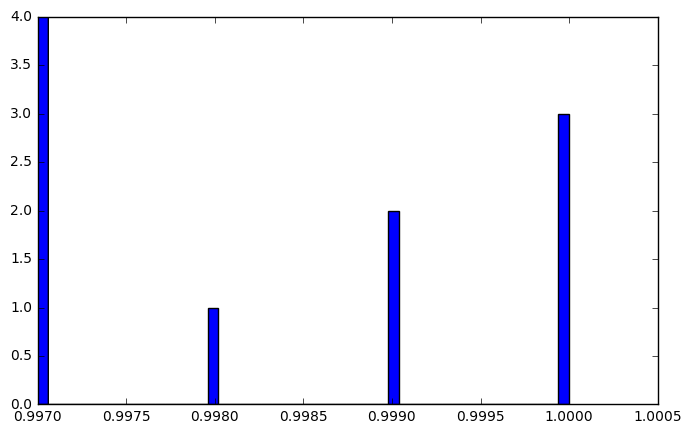

In [1]:
'''
*******************************************************************
In this file we test examples of application of the HMM class
functionality to reconstruct the parameters of a simulated
Hidden Markov process. We run many trials and save fitting
results and the actual HMM paramaters, thereby evaluating
performance of the HMM methods.
We focus on testing the following functionalities:
    * Reconstructing the transition probabilities matrix
    between the hidden states, using the Baum-Welch algorithm.
    
    * Reconstructing the emission probabilities matrix
    between the hidden states, using the Baum-Welch algorithm.
    
    * Reconstructing the hidden states time series using
    the Viterbi algorithm, when the actual transition 
    probabilities matrices are known.
We consider the case with 3 hidden states and 10 observable
states. During each trial we generate randomly the (pi,a,b)
parameters of the HMM. We then generate the time series for
the model with those parameters. The observable part of the 
time series is then put into the HMM, and used to reconstruct
the (pi,a,b), and the hidden states sequence. 
*******************************************************************
Put HMM.py into working directory, next to this file.
*******************************************************************
'''
import os
os.chdir('/workingdirectory')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import HMM


'''
Transition matrix elements (between the hidden/observable states)
and the Baum-Welch fit will be kept in data frames. We will
be keeping track of all the matrix components, where
the index of the component is used as a key of the
dictionary. The value of the dictionary is the data frame,
assembled over many trials.
'''

a_scoring={}
for i in range(3):
   for j in range(3):
       s=str(i)+'-'+str(j)
       a_scoring[s]=pd.DataFrame(columns=['real','fit'])
       
b_scoring={}
for i in range(3):
   for k in range(10):
       s=str(i)+'-'+str(k)
       b_scoring[s]=pd.DataFrame(columns=['real','fit'])
       
'''
Viterbi scores assembled over many trials. Counts what
fraction of times the Viterbi algorithm recovered the
underlying hidden state correctly.
'''

viterbi_scores=[]       

def prob_generator(size,position,a,b):
    '''
    Generate a list of size='size' of probabilities
    which sum up to one, where the 'leading' term is
    drawn randomly from (a,b) and positioned at the
    index='position'.
    '''
    leading=np.random.random()*(b-a)+a
    remaining=np.random.random(size-1)
    '''
    The remaining probabilities add up to 1-leading.
    '''
    remaining/=(np.sum(remaining)/(1-leading))
    remaining=list(remaining)
    remaining[-1]=1-leading-np.sum(remaining[:-1])
    '''
    Assemble the resulting list.
    '''
    ret=remaining[:position]+[leading]+remaining[position:]
    return ret
    
'''
Number of steps in the times series.
'''
steps=1000

'''
Run 10 trials
'''
for trial in range(10):  
    
    print trial
    
    '''
    The 'a' and 'b' matrices generated here are somewhat restricted,
    chosen so to result in a better performance of the HMM algorithms.
        
    Generate randomly the 'a' transition matrix of the size 3x3
    with the help of the prob_generator() function, putting a
    heavier weight on the diagonal entries.
    '''
    a=[]
    for r in range(3):
        a+=[prob_generator(3,r,0.95,0.98)]
    
    '''
    Generate randomly the 'b' emission matrix of the size 3x10
    with the help of the prob_generator() function, putting a
    heavier weight into a randomly selected position, different
    from the previously chosen randomly selected positions.
    '''
    b=[]
    random_heavy_weight=set()
    for r in range(3):
        p=np.random.randint(0,10)
        while p in random_heavy_weight:
            p=np.random.randint(0,10)
        random_heavy_weight.add(p)
        b+=[prob_generator(10,p,0.95,0.98)]
    
    '''
    Generate hidden sequence 'x', where each state is
    either of x_options=[0,1,2]. Initialize randomly.
    Use tha 'a' matrix so that 'x' is the Markov chain.
    ''' 
    x_options=[0,1,2]
    x=[np.random.randint(0,3)]
    for t in range(1,steps):
        x_last=x[-1]
        x+=[np.random.choice(x_options,1,p=a[x_last])[0]]

    '''
    Generate observed sequence 'y', using the found hidden
    sequence 'x'. Each observed state is either in y_options=0...9.
    '''
    y_options=range(0,10)
    y=[]
    for t in range(steps):
        y+=[np.random.choice(y_options,1,p=b[x[t]])[0]]
     
    '''
    Initialize the HMM.
    '''
    hmm1=HMM.HMM(y,3,y_options)
    
    '''
    Run Baum-Welch training over 100 steps.
    '''
    training_steps=100
    for i in range(training_steps):
        hmm1.BaumWelch()
        
    '''
    Add a row to the corresponding data frame, with the record 
    of the actual 'a' and 'b' matrices element and the found 
    Baum-Welch fits to it.
    '''    
    for i in range(3):
        for j in range(3):
            s=str(i)+'-'+str(j)
            a_scoring[s].loc[trial]=[a[i][j], hmm1.a[i][j]]
        for k in range(10):
            s=str(i)+'-'+str(k)
            b_scoring[s].loc[trial]=[b[i][k], hmm1.b[i][k]]  
            
    '''
    Run Viterbi algorithm and save what fraction of hidden
    'x' points has been identified correctly.
    
    Viterbi algorithm works best when we are in possession
    of the actual transition matrices. So use those.
    '''
    hmm1.a=a
    hmm1.b=b
    hmm1.pi=[0.33,0.33,0.34]
    
    hmm1.Viterbi()
    
    score=0
    for i in range(steps):
        score+=int(hmm1.estimate_x[i]==x[i])
    viterbi_scores+=[score/(steps+0.0)]
    
'''
In a 3 x 3 plot frame plot scatter points of the correpsponding
'a' matrix elements and their Baum-Welch fits. Similarly can be
done for the 'b' matrix.
'''                 

print "a matrix fit and real"

fig = plt.figure(figsize=(12,12))

ax00 = fig.add_subplot(331)
ax00.scatter(a_scoring['0-0'].real,a_scoring['0-0'].fit)


ax01 = fig.add_subplot(332)
ax01.scatter(a_scoring['0-1'].real,a_scoring['0-1'].fit)


ax02 = fig.add_subplot(333)
ax02.scatter(a_scoring['0-2'].real,a_scoring['0-2'].fit)


ax10 = fig.add_subplot(334)
ax10.scatter(a_scoring['1-0'].real,a_scoring['1-0'].fit)


ax11 = fig.add_subplot(335)
ax11.scatter(a_scoring['1-1'].real,a_scoring['1-1'].fit)


ax12 = fig.add_subplot(336)
ax12.scatter(a_scoring['1-2'].real,a_scoring['1-2'].fit)


ax20 = fig.add_subplot(337)
ax20.scatter(a_scoring['2-0'].real,a_scoring['2-0'].fit)


ax21 = fig.add_subplot(338)
ax21.scatter(a_scoring['2-1'].real,a_scoring['2-1'].fit)


ax22 = fig.add_subplot(339)
ax22.scatter(a_scoring['2-2'].real,a_scoring['2-2'].fit)


plt.show()
#fig.savefig("a_scores.pdf",dpi=400)

'''
Output Viterbi scores in a histogram.
'''

print "Viterbi scores"

fig=plt.figure(figsize=(8,5))
plt.hist(viterbi_scores,bins=50)
plt.show()
#fig.savefig("viterbi_fit.pdf",dpi=400)